# Multimodal understanding and generation with Janus-Pro and OpenVINO

Janus is a novel autoregressive framework that unifies multimodal understanding and generation. It addresses the limitations of previous approaches by decoupling visual encoding into separate pathways, while still utilizing a single, unified transformer architecture for processing. The decoupling not only alleviates the conflict between the visual encoder’s roles in understanding and generation, but also enhances the framework’s flexibility. Janus surpasses previous unified model and matches or exceeds the performance of task-specific models. The simplicity, high flexibility, and effectiveness of Janus make it a strong candidate for next-generation unified multimodal models.

More details can be found in the [paper](https://arxiv.org/abs/2410.13848), original [repository](https://github.com/deepseek-ai/Janus) and [model card](https://huggingface.co/deepseek-ai/Janus-1.3B)

Janus-Pro is an advanced version of Janus, significantly improving multimodal understanding and visual generation. More details can be found in [paper](https://github.com/deepseek-ai/Janus/blob/main/janus_pro_tech_report.pdf).

In this tutorial we consider how to run and optimize Janus using OpenVINO.
#### Table of contents:

- [Convert and Optimize model](#Convert-and-Optimize-model)
    - [Compress model weights to 4-bit](#Compress-model-weights-to-4-bit)
- [Create Inference Pipeline](#Create-Inference-Pipeline)
    - [Select Inference Device](#Select-Inference-Device)
    - [Run visual language chat](#Run-visual-language-chat)
    - [Run Image generation](#Run-Image-generation)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/janus-multimodal-generation/janus-multimodal-generation.ipynb" />


## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)

 Janus is PyTorch model. OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`. 

The script `ov_janus_helper.py` contains helper function for model conversion, please check its content if you interested in conversion details.

<details>
  <summary><b>Click here for more detailed explanation of conversion steps</b></summary>

Janus is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a token sequence can be decomposed into the product of conditional next token distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of generation token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this <a href="https://huggingface.co/blog/how-to-generate">blog</a>. The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the  <a href="https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate">documentation</a>. To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

For both tasks, image understanding and image generation, Janus utilizes the same basic transformer architecture in `language_model` and change only components responsible for preparing input embeddings (joined image embeddings prepared using `vision_embeddings_model` and text embeddings prepared using `text_embeddings_model` for image understanding and `text_embeddings_model` on the first step as initial prompt embeddings and `gen_embeddings_model` for the next) and conversion final hidden state to tokens probabilities (`lm_head` for text tokens, `gen_head` for image tokens). Additionally, for image generation model uses `gen_decoder` to convert generated image tokens to images.

To sum up above, model consists of 7 parts:
  * **Image Embeddings** for encoding input images into embedding space in image understanding task.
  * **Text Embedding** for conversion input text tokens into embedding space
  * **Gen Embeddings** for encoding image generation tokens to embeddings space in image generation task
  * **Language Model** for generation hidden state guided by input embeddings
  * **LM Head** for conversion Language Model hidden state to text generation token probabilities
  * **Gen Head** for conversion Language Model hidden state to image generation token probabilities
  * **Gen Decoder** for decoding generated image from latent token space to image tensor space.
  
For preserving original model flexibility of switching between tasks, we also should preserve original model partitioning and convert each model part separately. 

</details>


### Compress model weights to 4-bit
[back to top ⬆️](#Table-of-contents:)
For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). 

<details>
    <summary><b>Click here for more details about weight compression</b></summary>
Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).
</details>

In [2]:
from pathlib import Path
import sys
sys.path.append('..')
import nncf
from ov_janus_helper import convert_janus_model
import ipywidgets as widgets

model_ids = ["deepseek-ai/Janus-Pro-1B", "deepseek-ai/Janus-Pro-7B", "deepseek-ai/Janus-1.3B"]

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 64,
    "ratio": 1.0,
}

# uncomment the line to see model conversion code
# ??convert_janus_model

model_id = widgets.Dropdown(options=model_ids, value=model_ids[0])
model_id

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


<frozen importlib.util>:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


Python version is above 3.10, patching the collections module.


/home/ethan/intel/deepseek-workshop.openvino/openvino_test/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Dropdown(options=('deepseek-ai/Janus-Pro-1B', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/Janus-1.3B'), value='de…

In [3]:
from pathlib import Path

model_path = Path(model_id.value.split("/")[-1] + "-ov")
convert_janus_model(model_id.value, model_path, compression_configuration)

✅ Janus-Pro-1B model already converted. You can find results in Janus-Pro-1B-ov


## Create Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

`OVJanusModel` defined in `ov_janus_helper.py` provides unified interface for running model inference for both text and image generation. It accepts model directory and target device for inference.

### Select Inference Device
[back to top ⬆️](#Table-of-contents:)

In [4]:
from utils.notebook_utils import device_widget

device = device_widget("CPU", ["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [5]:
from ov_janus_helper import OVJanusModel
from janus.models import VLChatProcessor

# uncomment the line to see model inference code

# ??OVJanusModel

`VLChatPRocessor` class used for pre- and postprocessing steps in original Janus model. Our model is also compatible with the same processor code and we can reuse it.

In [6]:
ov_model = OVJanusModel(model_path, device.value)

processor = VLChatProcessor.from_pretrained(model_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some kwargs in processor config are unused and will not have any effect: sft_format, image_start_tag, image_end_tag, mask_prompt, add_special_token, num_image_tokens, ignore_id, image_tag, pad_tag. 


### Run visual language chat
[back to top ⬆️](#Table-of-contents:)

In [7]:
from PIL import Image
from io import BytesIO
from janus.utils.io import load_pil_images


input_prompt = "Describe image in details"
image_path = Path("cat_in_box.png")

if not image_path.exists():
    response = requests.get("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11")
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image.save(image_path)

conversation = [
    {
        "role": "User",
        "content": f"<image_placeholder>{input_prompt}\n",
        "images": [str(image_path)],
    },
    {"role": "Assistant", "content": ""},
]
pil_images = load_pil_images(conversation)

Question:
Describe image in details


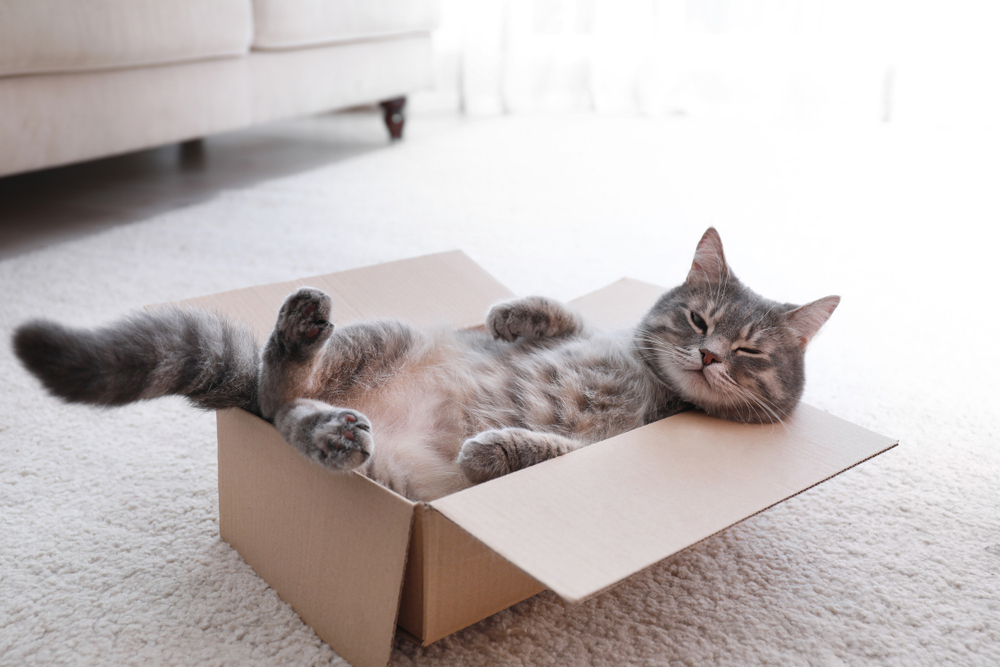

Answer:
The image shows a gray tabby cat lying on its back inside an open cardboard box. The cat appears to be relaxed and comfortable, with its belly exposed and its paws relaxed. The box is placed on a carpeted floor, and there is a beige sofa in the background. The overall setting appears to be a cozy indoor environment, likely a living room.


In [8]:
from transformers import TextStreamer

prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True)
# run image encoder to get the image embeddings
inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)

streamer = TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True)

print(f"Question:\n{input_prompt}")
display(pil_images[0])
print("Answer:")

answer_token_ids = ov_model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=processor.tokenizer.eos_token_id,
    bos_token_id=processor.tokenizer.bos_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=128,
    do_sample=False,
    streamer=streamer,
)

### Run Image generation
[back to top ⬆️](#Table-of-contents:)

In [13]:
from ov_janus_helper import generate_image

# Uncomment the line to see image generation code
# ??generate_image

In [17]:
from transformers import set_seed

set_seed(12345)

images = generate_image(
    ov_model,
    processor,
    "A close-up professional photo of Yorkshire Terrier on beach, extrimely detailed, hyper realistic, full hd",
    output_dir=None,
    parallel_size=1,
)

  0%|          | 0/576 [00:00<?, ?it/s]

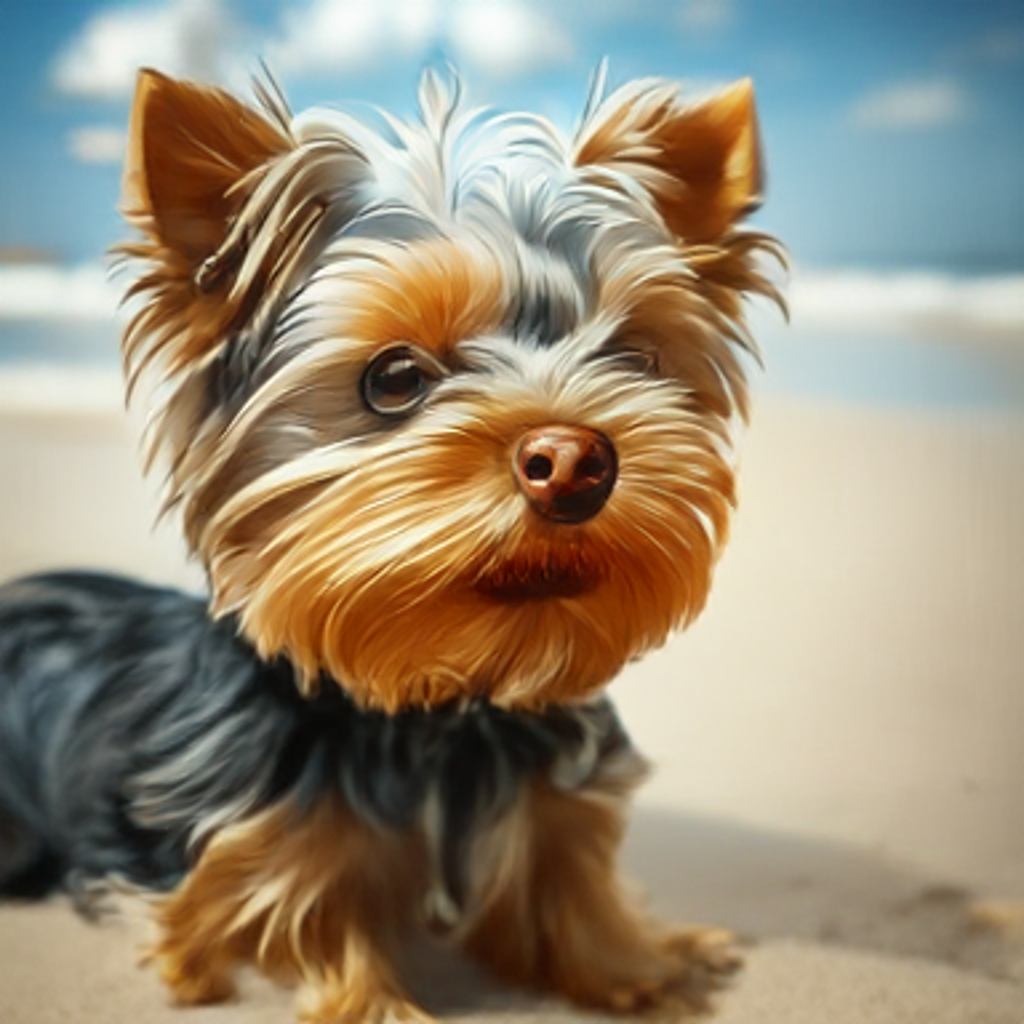

In [15]:
images[0].resize((1024, 1024))

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/